In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### 1. Importing Libraries

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision

#### 2. Input Data Details

In [21]:
def walk_through_dir(directory_name):
    
    '''
    Accepts the dirname as argument and prints the contents of each directory sequentially.
    It prints the sub-directories and number of images present in each.
    '''
    for dirpaths,dirnames,filenames in os.walk(directory_name):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpaths}'")

In [22]:
input_data_dir = './data/'
walk_through_dir(input_data_dir)

There are 4 directories and 0 images in './data/'
There are 0 directories and 7 images in './data/images to test'
There are 400 directories and 0 images in './data/test'
There are 0 directories and 5 images in './data/test\ABBOTTS BABBLER'
There are 0 directories and 5 images in './data/test\ABBOTTS BOOBY'
There are 0 directories and 5 images in './data/test\ABYSSINIAN GROUND HORNBILL'
There are 0 directories and 5 images in './data/test\AFRICAN CROWNED CRANE'
There are 0 directories and 5 images in './data/test\AFRICAN EMERALD CUCKOO'
There are 0 directories and 5 images in './data/test\AFRICAN FIREFINCH'
There are 0 directories and 5 images in './data/test\AFRICAN OYSTER CATCHER'
There are 0 directories and 5 images in './data/test\ALBATROSS'
There are 0 directories and 5 images in './data/test\ALBERTS TOWHEE'
There are 0 directories and 5 images in './data/test\ALEXANDRINE PARAKEET'
There are 0 directories and 5 images in './data/test\ALPINE CHOUGH'
There are 0 directories and 5 ima

#### 3.Visualizing the train data

In [23]:
train_dir='./data/train'
val_dir='./data/valid'
test_dir='./data/test'

In [25]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)
 
    plt.figure(figsize=(16,5))
    for i in range(5):
        
        plt.subplot(1,5,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False)

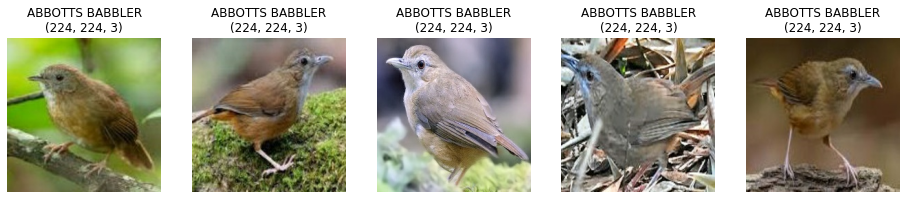

In [26]:
plot_random_image(train_dir)

#### 4.Converting the Input Data into batch Datasets

##### image_dataset_from_directory: data loader
##### tf.data.AUTOTUNE: buffer size is dynamically tuned

In [27]:
IMAGE_SIZE=(224,224)

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
class_names=train_data.class_names
num_classes=len(class_names)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

train_data_pf=train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf=val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_pf=test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


#### 5. model_0

#### 5.1 Define Data Augmentation Layer

In [28]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

#### 5.2 Create the model

##### include_top: Whether to include the fully-connected layer at the top of the network. Defaults to True.

In [29]:
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

x=data_augmentation(inputs)

x=base_model(x,training=False)

x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
num_classes=len(train_data.class_names)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="model")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6
16719872/16705208 [==============================] - 1s 0us/step


#### 5.3 Compile the model

In [30]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

#### 5.4 model summary

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_Layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pool_2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 400)               512400    
                                                                 
Total params: 4,561,971
Trainable params: 512,400
Non-trainab

#### 5.5 Fit the model

In [33]:
EPOCHS = 5
history_of_model = model.fit(train_data_pf, epochs=EPOCHS, 
                             steps_per_epoch=int(0.1*len(train_data_pf)),
                             validation_data = val_data_pf,
                             validation_steps = len(val_data_pf))

# why choose 0.1 in steps_per_epoch?

Epoch 1/5
182/182 [==============================] - 21s 70ms/step - loss: 4.4219 - accuracy: 0.2845 - val_loss: 2.7780 - val_accuracy: 0.5920
Epoch 2/5
182/182 [==============================] - 11s 63ms/step - loss: 2.2809 - accuracy: 0.6272 - val_loss: 1.5114 - val_accuracy: 0.7920
Epoch 3/5
182/182 [==============================] - 12s 64ms/step - loss: 1.5069 - accuracy: 0.7455 - val_loss: 0.9929 - val_accuracy: 0.8745
Epoch 4/5
182/182 [==============================] - 12s 64ms/step - loss: 1.1779 - accuracy: 0.7891 - val_loss: 0.7339 - val_accuracy: 0.9085
Epoch 5/5
182/182 [==============================] - 12s 65ms/step - loss: 1.0006 - accuracy: 0.8149 - val_loss: 0.5861 - val_accuracy: 0.9200


#### 5.6 model_0 result

In [34]:
model_0_result=model.evaluate(test_data_pf)
model_0_result

63/63 [==============================] - 3s 43ms/step - loss: 0.5526 - accuracy: 0.9360


[0.5525920987129211, 0.9359999895095825]

In [36]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

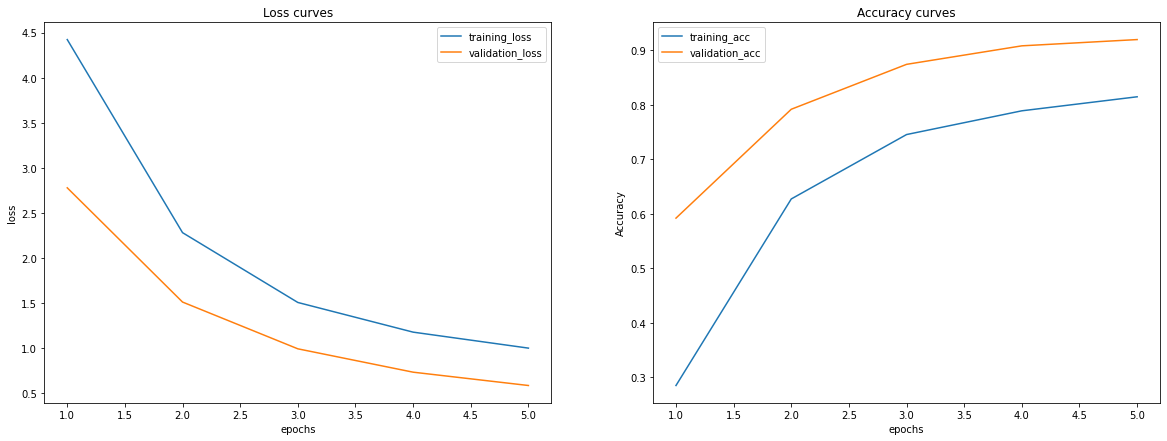

In [37]:
plot_loss_curves(history_of_model)

#### 6. model_1

In [38]:
mixed_precision.set_global_policy('mixed_float16')

#### 6.1 Create the model

In [40]:
inputs = layers.Input(shape=(224,224,3), name='input_layer')

base_model = keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

x = data_augmentation(inputs)

x = base_model(x, training=True)

x = layers.GlobalAveragePooling2D(name='Glabal_Average_Poll_2D')(x)
num_classes = len(train_data.class_names)
outputs = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='Output_layer')(x)

model = keras.Model(inputs, outputs, name='model')

#### 6.2 Complie the model

In [42]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#### 6.3 Define Model Check Point Callback Function

In [43]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
        
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

#### 6.4 Fit the model

In [44]:
ModelCheckPoint_model_cb=create_model_check_point_callback('./ModelCheckPoints/model_1.ckpt')

EPOCHS=5
history_of_model_1=model.fit(
    train_data_pf,
    epochs=EPOCHS,
    steps_per_epoch=len(train_data_pf),
    validation_data=val_data_pf,
    validation_steps=len(val_data_pf),
    callbacks=[ModelCheckPoint_model_cb]
)

Epoch 1/5
1825/1825 [==============================] - ETA: 0s - loss: 1.4933 - accuracy: 0.7323
Epoch 1: val_loss improved from inf to 0.35089, saving model to ./ModelCheckPoints\model_1.ckpt
1825/1825 [==============================] - 100s 53ms/step - loss: 1.4933 - accuracy: 0.7323 - val_loss: 0.3509 - val_accuracy: 0.9410
Epoch 2/5
1825/1825 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.8860
Epoch 2: val_loss improved from 0.35089 to 0.21220, saving model to ./ModelCheckPoints\model_1.ckpt
1825/1825 [==============================] - 96s 53ms/step - loss: 0.5047 - accuracy: 0.8860 - val_loss: 0.2122 - val_accuracy: 0.9535
Epoch 3/5
1825/1825 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.9122
Epoch 3: val_loss improved from 0.21220 to 0.17272, saving model to ./ModelCheckPoints\model_1.ckpt
1825/1825 [==============================] - 96s 53ms/step - loss: 0.3674 - accuracy: 0.9122 - val_loss: 0.1727 - val_accuracy: 0.9585
Epoch 4

#### 6.5 model_1 result

In [45]:
#load the best weights saved using modelCheckPoint callback
model.load_weights('./ModelCheckPoints/model_1.ckpt')
model_1_result=model.evaluate(test_data_pf)
model_1_result

63/63 [==============================] - 3s 46ms/step - loss: 0.1155 - accuracy: 0.9770


[0.11547501385211945, 0.9769999980926514]

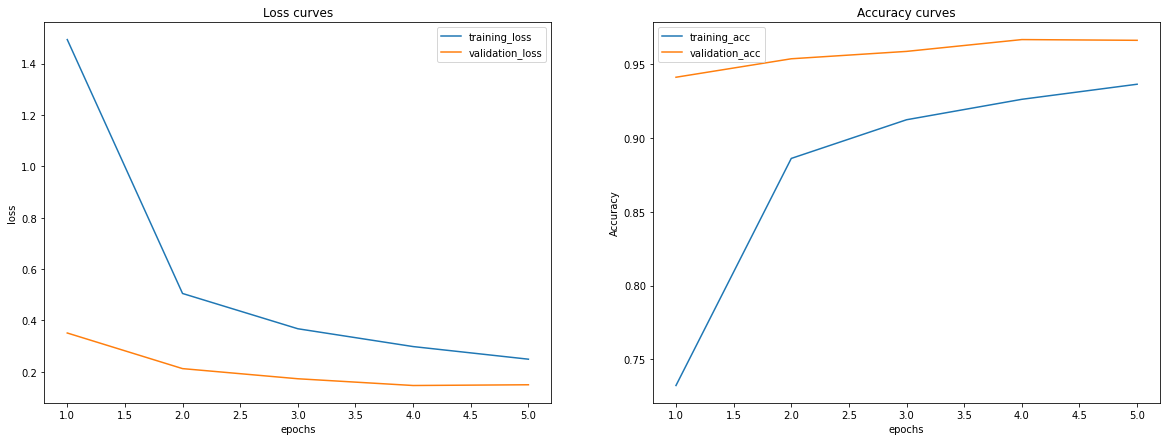

In [46]:
plot_loss_curves(history_of_model_1)

#### 7. model_2

#### 7.1 unfreeze the top 10 layers of the feature extraction model

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_Layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Glabal_Average_Poll_2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 400)               512400    
                                                                 
Total params: 4,561,971
Trainable params: 512,400
Non-trainab

In [48]:
# umfreeze top 10 layers 
model.layers[2].trainable=True
for layer in model.layers[2].layers[:-10]:
    layer.trainable=False

In [49]:
# check the number of trainable layers in feature extraction model
len(model.layers[2].trainable_variables)

10

#### 7.2 Recompile the model

In [50]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

#### 7.3 Define Early Stopping and Reduce Learning Rate callback

In [51]:
early_stop_cb=tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
reduce_lr_cb=tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,verbose=1,min_lr=1e-7,min_delta=1e-3)

#### 7.4 Fit the model

In [52]:
ModelCheckPoint_model_cb=create_model_check_point_callback('./ModelCheckPoints/model_2.ckpt')

fine_tune_epochs=EPOCHS+20
history_of_model_2=model.fit(
    train_data_pf,
    epochs=fine_tune_epochs,
    initial_epoch=EPOCHS-1,
    steps_per_epoch=len(train_data_pf),
    validation_data=val_data_pf,
    validation_steps=len(val_data_pf),
    callbacks=[ModelCheckPoint_model_cb,early_stop_cb,reduce_lr_cb]
)

Epoch 5/25
1825/1825 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9440
Epoch 5: val_loss improved from inf to 0.11835, saving model to ./ModelCheckPoints\model_2.ckpt
1825/1825 [==============================] - 107s 56ms/step - loss: 0.2352 - accuracy: 0.9440 - val_loss: 0.1184 - val_accuracy: 0.9710 - lr: 1.0000e-04
Epoch 6/25
1824/1825 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9551
Epoch 6: val_loss improved from 0.11835 to 0.10581, saving model to ./ModelCheckPoints\model_2.ckpt
1825/1825 [==============================] - 101s 55ms/step - loss: 0.1823 - accuracy: 0.9551 - val_loss: 0.1058 - val_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 7/25
1825/1825 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9619
Epoch 7: val_loss did not improve from 0.10581
1825/1825 [==============================] - 100s 55ms/step - loss: 0.1548 - accuracy: 0.9619 - val_loss: 0.1125 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoc

#### 7.5 model_2 result

In [53]:
model_2_val_result=model.evaluate(val_data_pf)
model_2_val_result

63/63 [==============================] - 3s 46ms/step - loss: 0.0884 - accuracy: 0.9740


[0.08837471902370453, 0.9739999771118164]

In [54]:
model_2_test_result=model.evaluate(test_data_pf)
model_2_test_result

63/63 [==============================] - 3s 46ms/step - loss: 0.1379 - accuracy: 0.9595


[0.13794754445552826, 0.9595000147819519]

In [ ]:
def plot_and_compare_history(original_history,new_history,initial_epoch):
    """
    the function accepts the histories of a model before and after fine-tunning.
    initial_epoch:#epochs used to train the original model.
    """
    #get original history measurements
    acc=original_history.history['accuracy']
    loss=original_history.history['loss']
    val_acc=original_history.history['val_accuracy']
    val_loss=original_history.history['val_loss']
    
    #combining 
    total_acc=acc+new_history.history['accuracy']
    total_loss=loss+new_history.history['loss']
    total_val_acc=val_acc+new_history.history['val_accuracy']
    total_val_loss=val_loss+new_history.history['val_loss']
    
    #make plots
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(total_acc,label='Training Accuracy')    
    plt.plot(total_val_acc,label='Validation Accuracy')
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Accuracy")
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.plot(total_loss,label='Training loss')
    plt.plot(total_val_loss,label="Validation loss")
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Loss")
    plt.legend(loc="upper right")

In [55]:
plot_and_compare_history(history_of_model_1,history_of_model_2,initial_epoch=EPOCHS)

NameError: name 'plot_and_compare_history' is not defined

#### 8. model_3

In [ ]:
# loading the best weights of model_1
model.load_weights('./ModelCheckPoints/model_1.ckpt')

#### 8.1 unfreezing all layers

In [ ]:
model.layers[2].trainable=True

In [ ]:
# checking the number of trainable layers in feature extraction model
len(model.layers[2].trainable_variables)

#### 8.2 Recompile the model

In [ ]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

#### 8.3 Fit the model

In [ ]:
# callbacks
ModelCheckPoint_model_cb=create_model_check_point_callback('./ModelCheckPoints/model_3.ckpt')
early_stop_cb=tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
reduce_lr_cb=tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,verbose=1,min_lr=1e-7,min_delta=1e-3)

fine_tune_epochs=EPOCHS+20
history_of_model_3=model.fit(
    train_data_pf,
    epochs=fine_tune_epochs,
    initial_epoch=EPOCHS-1,
    steps_per_epoch=len(train_data_pf),
    validation_data=val_data_pf,
    validation_steps=len(val_data_pf),
    callbacks=[ModelCheckPoint_model_cb,early_stop_cb,reduce_lr_cb]
)

#### 8.4 model_3 result

In [ ]:
model_3_val_result=model.evaluate(val_data_pf)
model_3_val_result

In [ ]:
model_3_test_result=model.evaluate(test_data_pf)
model_3_test_result

In [ ]:
plot_and_compare_history(history_of_model_1,history_of_model_3,initial_epoch=EPOCHS)